In [8]:
%%sql
CREATE TABLE `stockTable` (
    `ticker` varchar(20) CHARACTER SET utf8 COLLATE utf8_general_ci DEFAULT NULL,
    `created_at` datetime DEFAULT NULL,
    `open` float DEFAULT NULL,
    `high` float DEFAULT NULL,
    `low` float DEFAULT NULL,
    `close` float DEFAULT NULL,
    `volume` int(11) DEFAULT NULL,
    SORT KEY (ticker, created_at desc),
    SHARD KEY (ticker)
);

CREATE TABLE newsSentiment (
    title TEXT CHARACTER SET utf8mb4,
    url TEXT,
    time_published DATETIME,
    authors TEXT,
    summary TEXT CHARACTER SET utf8mb4,
    banner_image TEXT,
    source TEXT,
    category_within_source TEXT,
    source_domain TEXT,
    topic TEXT,
    topic_relevance_score TEXT,
    overall_sentiment_score REAL,
    overall_sentiment_label TEXT,
    `ticker` varchar(20) CHARACTER SET utf8 COLLATE utf8_general_ci DEFAULT NULL,
    ticker_relevance_score DECIMAL(10, 6),
    ticker_sentiment_score DECIMAL(10, 6),
    ticker_sentiment_label TEXT,
    SORT KEY (`ticker`,`time_published` DESC),
    SHARD KEY `__SHARDKEY` (`ticker`,`time_published` DESC),
    KEY(ticker) USING HASH,
    KEY(authors) USING HASH,
    KEY(source) USING HASH,
    KEY(overall_sentiment_label) USING HASH,
    KEY(ticker_sentiment_label) USING HASH
);

CREATE ROWSTORE REFERENCE TABLE companyInfo (
    ticker VARCHAR(10) PRIMARY KEY,
    AssetType VARCHAR(50),
    Name VARCHAR(100),
    Description TEXT,
    CIK VARCHAR(10),
    Exchange VARCHAR(10),
    Currency VARCHAR(10),
    Country VARCHAR(50),
    Sector VARCHAR(50),
    Industry VARCHAR(250),
    Address VARCHAR(100),
    FiscalYearEnd VARCHAR(20),
    LatestQuarter DATE,
    MarketCapitalization BIGINT,
    EBITDA BIGINT,
    PERatio DECIMAL(10, 2),
    PEGRatio DECIMAL(10, 3),
    BookValue DECIMAL(10, 2),
    DividendPerShare DECIMAL(10, 2),
    DividendYield DECIMAL(10, 4),
    EPS DECIMAL(10, 2),
    RevenuePerShareTTM DECIMAL(10, 2),
    ProfitMargin DECIMAL(10, 4),
    OperatingMarginTTM DECIMAL(10, 4),
    ReturnOnAssetsTTM DECIMAL(10, 4),
    ReturnOnEquityTTM DECIMAL(10, 4),
    RevenueTTM BIGINT,
    GrossProfitTTM BIGINT,
    DilutedEPSTTM DECIMAL(10, 2),
    QuarterlyEarningsGrowthYOY DECIMAL(10, 3),
    QuarterlyRevenueGrowthYOY DECIMAL(10, 3),
    AnalystTargetPrice DECIMAL(10, 2),
    TrailingPE DECIMAL(10, 2),
    ForwardPE DECIMAL(10, 2),
    PriceToSalesRatioTTM DECIMAL(10, 3),
    PriceToBookRatio DECIMAL(10, 2),
    EVToRevenue DECIMAL(10, 3),
    EVToEBITDA DECIMAL(10, 2),
    Beta DECIMAL(10, 3),
    52WeekHigh DECIMAL(10, 2),
    52WeekLow DECIMAL(10, 2),
    50DayMovingAverage DECIMAL(10, 2),
    200DayMovingAverage DECIMAL(10, 2),
    SharesOutstanding BIGINT,
    DividendDate DATE,
    ExDividendDate DATE
);

CREATE TABLE `embeddings` (
    `id` bigint(11) NOT NULL AUTO_INCREMENT,
    `category` varchar(255) CHARACTER SET utf8 COLLATE utf8_general_ci DEFAULT NULL,
    `question` longtext CHARACTER SET utf8 COLLATE utf8_general_ci,
    `question_embedding` longblob,
    `answer` longtext CHARACTER SET utf8 COLLATE utf8_general_ci,
    `answer_embedding` longblob,
    `created_at` datetime DEFAULT NULL,
    UNIQUE KEY `PRIMARY` (`id`) USING HASH,
    SHARD KEY `__SHARDKEY` (`id`),
    KEY `category` (`category`) USING HASH,
    SORT KEY `__UNORDERED` (`created_at` DESC)
);

++
||
++
++

In [9]:
%%sql
SHOW TABLES;

Tables_in_llm_webinar
companyInfo
embeddings
newsSentiment
stockTable


In [10]:
!pip install elevenlabs --quiet
!pip install openai==0.28 --quiet
!pip install matplotlib --quiet
!pip install scipy --quiet
!pip install scikit-learn --quiet
!pip install singlestoredb --quiet
!pip install langchain --quiet

In [11]:
import datetime
import getpass
import numpy as np
import openai
import requests
import singlestoredb as s2
import time
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from langchain.sql_database import SQLDatabase
from langchain.llms.openai import OpenAI
from langchain.agents.agent_toolkits import SQLDatabaseToolkit
from langchain.agents import create_sql_agent
from openai.embeddings_utils import get_embeddings

In [16]:
alpha_vantage_apikey = getpass.getpass("enter alphavantage apikey here")
openai_apikey = getpass.getpass("enter openai apikey here")
elevenlabs_apikey = getpass.getpass("enter elevenlabs apikey here")

enter alphavantage apikey here ········
enter openai apikey here ········
enter elevenlabs apikey here ········


In [57]:
# set up connection to SingleStore and the ticker list
s2_conn = s2.connect(connection_url)
ticker_list = ['TSLA', 'AMZN', 'PLTR']

In [59]:
from datetime import datetime

def get_past_months(num_months):
    today = datetime.today()
    months = []

    for months_ago in range(0, num_months):
        target_date = today - relativedelta(months=months_ago)
        months.append(target_date.strftime('%Y-%m'))

    return months

num_months = 2  # Number of months
year_month_list = get_past_months(num_months)
print(year_month_list)

['2023-12', '2023-11']


In [70]:
# pull intraday data for each stock and write to SingleStore
for ticker in ticker_list:
    print(ticker)
    data_list = []
    for year_month in year_month_list:
        print(year_month)

        intraday_price_url = "https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={}&interval=5min&month={}&outputsize=full&apikey={}".format(ticker, year_month, alpha_vantage_apikey)
        r = requests.get(intraday_price_url)

        try:
            data = r.json()['Time Series (5min)']
        except:
            time.sleep(1) # required to not hit API limits
            continue

        for key in data:
            document = data[key]
            document['datetime'] = key
            document['ticker'] = ticker

            document['open'] = document['1. open']
            document['high'] = document['2. high']
            document['low'] = document['3. low']
            document['close'] = document['4. close']
            document['volume'] = document['5. volume']

            document['open'] = float(document['open'])
            document['high'] = float(document['high'])
            document['low'] = float(document['low'])
            document['close'] = float(document['close'])
            document['volume'] = int(document['volume'])


            del document['1. open']
            del document['2. high']
            del document['3. low']
            del document['4. close']
            del document['5. volume']

            data_list += [document]

            # Inside your loop, create the params dictionary with the correct values
            params = {
                'datetime': document['datetime'],
                'ticker': ticker,
                'open': document['open'],
                'high': document['high'],
                'low': document['low'],
                'close': document['close'],
                'volume': document['volume']
            }

            # Construct and execute the SQL statement
            table_name = 'stockTable'
            stmt = f"INSERT INTO {table_name} (created_at, ticker, open, high, low, close, volume) VALUES (%(datetime)s, %(ticker)s, %(open)s, %(high)s, %(low)s, %(close)s, %(volume)s)"

            with s2_conn.cursor() as cur:
                cur.execute(stmt, params)
        # time.sleep(1) # required to not hit API limits

TSLA
2023-12
2023-11
AMZN
2023-12
2023-11
PLTR
2023-12
2023-11


In [84]:
%%sql
select count(*) from stockTable

count(*)
14422


In [93]:
# pull intraday data for each stock and write to SingleStore
for ticker in ticker_list:
    print(ticker)
    data_list = []
    # for year_month in year_month_list:

    company_overview = "https://www.alphavantage.co/query?function=OVERVIEW&symbol={}&outputsize=full&apikey={}".format(ticker, alpha_vantage_apikey)
    r = requests.get(company_overview)

    try:
        data = r.json()
    except:
        time.sleep(3) # required to not hit API limits
        continue

    data['CIK'] = int(data['CIK'])
    data['MarketCapitalization']= float(data['MarketCapitalization'])
    # Assuming data['EBITDA'] is a string containing 'None'
    ebitda_str = data['EBITDA']
    if ebitda_str.lower() == 'none':
        # Handle the case where EBITDA is 'None', for example, you can set it to 0
        data['EBITDA'] = 0.0
    else:
        # Convert the EBITDA string to a float
        data['EBITDA'] = float(ebitda_str)

    PERatio_flt = data['PERatio']
    if PERatio_flt.lower() == 'none':
        # Handle the case where EVToRevenue is '-'
        data['PERatio'] = 0.0  # You can use any default value that makes sense
    else:
        # Convert the EVToRevenue string to a float
        data['PERatio'] = float(PERatio_flt)

    data['PEGRatio']= float(data['PEGRatio'])
    data['BookValue']= float(data['BookValue'])
    data['DividendPerShare']= float(data['DividendPerShare'])
    data['DividendYield']= float(data['DividendYield'])
    data['EPS']= float(data['EPS'])
    data['RevenuePerShareTTM']= float(data['RevenuePerShareTTM'])
    data['ProfitMargin']= float(data['ProfitMargin'])
    data['OperatingMarginTTM']= float(data['OperatingMarginTTM'])
    data['ReturnOnAssetsTTM']= float(data['ReturnOnAssetsTTM'])
    data['ReturnOnEquityTTM']= float(data['ReturnOnEquityTTM'])
    data['RevenueTTM']= int(data['RevenueTTM'])
    data['GrossProfitTTM']= int(data['GrossProfitTTM'])
    data['DilutedEPSTTM']= float(data['DilutedEPSTTM'])
    data['QuarterlyEarningsGrowthYOY']= float(data['QuarterlyEarningsGrowthYOY'])
    data['QuarterlyRevenueGrowthYOY']= float(data['QuarterlyRevenueGrowthYOY'])
    data['AnalystTargetPrice']= float(data['AnalystTargetPrice'])
    # Assuming data['TrailingPE'] is a string containing '-'
    trailing_pe_str = data['TrailingPE']
    if trailing_pe_str == '-':
        # Handle the case where TrailingPE is '-'
        data['TrailingPE'] = 0.0  # You can use any default value that makes sense
    else:
        try:
            # Attempt to convert the TrailingPE string to a float
            data['TrailingPE'] = float(trailing_pe_str)
        except ValueError:
            # Handle the case where the conversion fails (e.g., if it contains invalid characters)
            data['TrailingPE'] = 0.0  # Set to a default value or handle as needed

    data['ForwardPE']= float(data['ForwardPE'])
    data['PriceToSalesRatioTTM']= float(data['PriceToSalesRatioTTM'])
    # Assuming data['EVToRevenue'] is a string containing '-'
    PriceToBookRatio_flt = data['PriceToBookRatio']
    if PriceToBookRatio_flt == '-':
        # Handle the case where EVToRevenue is '-'
        data['PriceToBookRatio'] = 0.0  # You can use any default value that makes sense
    else:
        # Convert the EVToRevenue string to a float
        data['PriceToBookRatio'] = float(PriceToBookRatio_flt)

    # Assuming data['EVToRevenue'] is a string containing '-'
    ev_to_revenue_str = data['EVToRevenue']
    if ev_to_revenue_str == '-':
        # Handle the case where EVToRevenue is '-'
        data['EVToRevenue'] = 0.0  # You can use any default value that makes sense
    else:
        # Convert the EVToRevenue string to a float
        data['EVToRevenue'] = float(ev_to_revenue_str)

    # data['EVToEBITDA']= float(data['EVToEBITDA'])
    # Assuming data['EVToRevenue'] is a string containing '-'
    ev_to_EBITDA_str = data['EVToEBITDA']
    if ev_to_revenue_str == '-':
        # Handle the case where EVToRevenue is '-'
        data['EVToEBITDA'] = 0.0  # You can use any default value that makes sense
    else:
        # Convert the EVToRevenue string to a float
        data['EVToEBITDA'] = float(ev_to_EBITDA_str)

    data['Beta']= float(data['Beta'])
    data['52WeekHigh']= float(data['52WeekHigh'])
    data['52WeekLow']= float(data['52WeekLow'])
    data['50DayMovingAverage']= float(data['50DayMovingAverage'])
    data['200DayMovingAverage']= float(data['200DayMovingAverage'])
    data['SharesOutstanding']= int(data['SharesOutstanding'])
    
    # description_embedding = [np.array(x, '<f4') for x in get_embeddings(data["Description"], engine=model)]
    dividend_date_str = data['DividendDate']
    if dividend_date_str.lower() == 'none':
        # Handle the case where EBITDA is 'None', for example, you can set it to 0
        data['DividendDate'] = '9999-12-31'
    else:
        # Convert the EBITDA string to a float
        data['DividendDate'] = str(dividend_date_str)

    exdividend_date_str = data['ExDividendDate']
    if exdividend_date_str.lower() == 'none':
        # Handle the case where EBITDA is 'None', for example, you can set it to 0
        data['ExDividendDate'] = '9999-12-31'
    else:
        # Convert the EBITDA string to a float
        data['ExDividendDate'] = str(exdividend_date_str)

    data_list += [data]

    # Inside your loop, create the params dictionary with the correct values
    params = {
                "Symbol": data["Symbol"],
                "AssetType": data["AssetType"],
                "Name": data["Name"],
                "Description": data["Description"],
                "CIK": data["CIK"],
                "Exchange": data["Exchange"],
                "Currency": data["Currency"],
                "Country": data["Country"],
                "Sector": data["Sector"],
                "Industry": data["Industry"],
                "Address": data["Address"],
                "FiscalYearEnd": data["FiscalYearEnd"],
                "LatestQuarter": data["LatestQuarter"],
                "MarketCapitalization": data["MarketCapitalization"],
                "EBITDA": data["EBITDA"],
                "PERatio": data["PERatio"],
                "PEGRatio": data["PEGRatio"],
                "BookValue": data["BookValue"],
                "DividendPerShare": data["DividendPerShare"],
                "DividendYield": data["DividendYield"],
                "EPS": data["EPS"],
                "RevenuePerShareTTM": data["RevenuePerShareTTM"],
                "ProfitMargin": data["ProfitMargin"],
                "OperatingMarginTTM": data["OperatingMarginTTM"],
                "ReturnOnAssetsTTM": data["ReturnOnAssetsTTM"],
                "ReturnOnEquityTTM": data["ReturnOnEquityTTM"],
                "RevenueTTM": data["RevenueTTM"],
                "GrossProfitTTM": data["GrossProfitTTM"],
                "DilutedEPSTTM": data["DilutedEPSTTM"],
                "QuarterlyEarningsGrowthYOY": data["QuarterlyEarningsGrowthYOY"],
                "QuarterlyRevenueGrowthYOY": data["QuarterlyRevenueGrowthYOY"],
                "AnalystTargetPrice": data["AnalystTargetPrice"],
                "TrailingPE": data["TrailingPE"],
                "ForwardPE": data["ForwardPE"],
                "PriceToSalesRatioTTM": data["PriceToSalesRatioTTM"],
                "PriceToBookRatio": data["PriceToBookRatio"],
                "EVToRevenue": data["EVToRevenue"],
                "EVToEBITDA": data["EVToEBITDA"],
                "Beta": data["Beta"],
                "52WeekHigh": data["52WeekHigh"],
                "52WeekLow": data["52WeekLow"],
                "50DayMovingAverage": data["50DayMovingAverage"],
                "200DayMovingAverage": data["200DayMovingAverage"],
                "SharesOutstanding": data["SharesOutstanding"],
                "DividendDate": data["DividendDate"],
                "ExDividendDate": data["ExDividendDate"]
    }

     # Construct and execute the SQL statement
    table_name = 'companyInfo'
    stmt = f"INSERT INTO {table_name} (ticker, AssetType, Name, Description, CIK, Exchange, Currency, Country, Sector, Industry, Address, FiscalYearEnd, LatestQuarter, MarketCapitalization, EBITDA, PERatio, PEGRatio, BookValue, DividendPerShare, DividendYield, EPS, RevenuePerShareTTM, ProfitMargin, OperatingMarginTTM, ReturnOnAssetsTTM, ReturnOnEquityTTM, RevenueTTM, GrossProfitTTM, DilutedEPSTTM, QuarterlyEarningsGrowthYOY, QuarterlyRevenueGrowthYOY, AnalystTargetPrice, TrailingPE, ForwardPE, PriceToSalesRatioTTM, PriceToBookRatio, EVToRevenue, EVToEBITDA, Beta, 52WeekHigh, 52WeekLow, 50DayMovingAverage, 200DayMovingAverage, SharesOutstanding, DividendDate, ExDividendDate) VALUES (%(Symbol)s, %(AssetType)s, %(Name)s, %(Description)s, %(CIK)s, %(Exchange)s, %(Currency)s, %(Country)s, %(Sector)s, %(Industry)s, %(Address)s, %(FiscalYearEnd)s, %(LatestQuarter)s, %(MarketCapitalization)s, %(EBITDA)s, %(PERatio)s, %(PEGRatio)s, %(BookValue)s, %(DividendPerShare)s, %(DividendYield)s, %(EPS)s, %(RevenuePerShareTTM)s, %(ProfitMargin)s, %(OperatingMarginTTM)s, %(ReturnOnAssetsTTM)s, %(ReturnOnEquityTTM)s, %(RevenueTTM)s, %(GrossProfitTTM)s, %(DilutedEPSTTM)s, %(QuarterlyEarningsGrowthYOY)s, %(QuarterlyRevenueGrowthYOY)s, %(AnalystTargetPrice)s, %(TrailingPE)s, %(ForwardPE)s, %(PriceToSalesRatioTTM)s, %(PriceToBookRatio)s, %(EVToRevenue)s, %(EVToEBITDA)s, %(Beta)s, %(52WeekHigh)s, %(52WeekLow)s, %(50DayMovingAverage)s, %(200DayMovingAverage)s, %(SharesOutstanding)s, %(DividendDate)s, %(ExDividendDate)s)"

# Replace table_name with the actual table name you're using.
    with s2_conn.cursor() as cur:
        cur.execute(stmt, params)

TSLA
AMZN
PLTR


In [98]:
%%sql
select * from companyInfo limit 1

ticker,AssetType,Name,Description,CIK,Exchange,Currency,Country,Sector,Industry,Address,FiscalYearEnd,LatestQuarter,MarketCapitalization,EBITDA,PERatio,PEGRatio,BookValue,DividendPerShare,DividendYield,EPS,RevenuePerShareTTM,ProfitMargin,OperatingMarginTTM,ReturnOnAssetsTTM,ReturnOnEquityTTM,RevenueTTM,GrossProfitTTM,DilutedEPSTTM,QuarterlyEarningsGrowthYOY,QuarterlyRevenueGrowthYOY,AnalystTargetPrice,TrailingPE,ForwardPE,PriceToSalesRatioTTM,PriceToBookRatio,EVToRevenue,EVToEBITDA,Beta,52WeekHigh,52WeekLow,50DayMovingAverage,200DayMovingAverage,SharesOutstanding,DividendDate,ExDividendDate
AMZN,Common Stock,Amazon.com Inc,"Amazon.com, Inc. is an American multinational technology company which focuses on e-commerce, cloud computing, digital streaming, and artificial intelligence. It is one of the Big Five companies in the U.S. information technology industry, along with Google, Apple, Microsoft, and Facebook. The company has been referred to as one of the most influential economic and cultural forces in the world, as well as the world's most valuable brand.",1018724,NASDAQ,USD,USA,TRADE & SERVICES,RETAIL-CATALOG & MAIL-ORDER HOUSES,"410 TERRY AVENUE NORTH, SEATTLE, WA, US",December,2023-09-30,1493469757000,73978003000,75.66,2.383,17.71,0.00,0.0000,1.91,53.95,0.0362,0.0782,0.0361,0.1250,554027975000,225152000000,1.91,2.357,0.126,173.56,75.66,38.17,2.696,8.16,2.827,21.28,1.170,149.26,81.43,135.57,122.92,10334000000,9999-12-31,9999-12-31


In [101]:
import datetime

# pull intraday data for each stock and write to Mongo
for ticker in ticker_list:
    print(ticker)
    data_list = []

    for i in year_month_list:
        date_object = datetime.datetime.strptime(i, '%Y-%m')
        print(date_object)
        output_date = date_object.strftime('%Y%m%d') + "T0000"

        # Get the next month from the 'date_object'
        previous_month_date = date_object + relativedelta(months=-1)
        previous_month_date = previous_month_date.strftime('%Y%m%d') + "T0000"

        # Update 'date_object' for the next iteration
        date_object = previous_month_date

        # replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
        news_and_sentiment = 'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={}&time_from={}&time_to={}&limit=1000&outputsize=full&apikey={}'.format(ticker, previous_month_date, output_date, alpha_vantage_apikey)
        r = requests.get(news_and_sentiment)

        try:
            data = r.json()
            data = data["feed"]
        except:
            time.sleep(2) # required to not hit API limits
            continue

        for item in data:
            item['title'] = str(item['title'])
            item['url'] = str(item['url'])
            item['time_published'] = datetime.datetime.strptime(str(item['time_published']), "%Y%m%dT%H%M%S").strftime("%Y-%m-%d %H:%M:%S")

            if item['authors']:
                # Check if the 'authors' list is not empty
                authors_str = str(item['authors'][0])
            else:
                # Handle the case where 'authors' is empty
                authors_str = "No authors available"

            item['authors'] = authors_str

            item['summary'] = str(item['summary'])
            item['banner_image'] = str(item['banner_image'])
            item['source'] = str(item['source'])
            item['category_within_source'] = str(item['category_within_source'])
            item['source_domain'] = str(item['source_domain'])
            item['topic'] = str(item['topics'][0]["topic"])
            item['topic_relevance_score'] = float(item['topics'][0]['relevance_score'])
            item['overall_sentiment_score'] = float(item['overall_sentiment_score'])
            item['overall_sentiment_label'] = str(item['overall_sentiment_label'])
            item['ticker'] = str(item['ticker_sentiment'][0]['ticker'])
            item['ticker_relevance_score'] = float(item['ticker_sentiment'][0]['relevance_score'])
            item['ticker_sentiment_score'] = float(item['ticker_sentiment'][0]['ticker_sentiment_score'])
            item['ticker_sentiment_label'] = str(item['ticker_sentiment'][0]['ticker_sentiment_label'])

            params= {
                "title": item["title"],
                "url": item["url"],
                "time_published": item["time_published"],
                "authors": item["authors"],
                "summary": item["summary"],
                "banner_image": item["banner_image"],
                "source": item["source"],
                "category_within_source": item["category_within_source"],
                "source_domain": item["source_domain"],
                "topic": item["topic"],
                "topic_relevance_score": item['topic_relevance_score'],
                'overall_sentiment_score': item['overall_sentiment_score'],
                'overall_sentiment_label': item['overall_sentiment_label'],
                'ticker': item['ticker'],
                'ticker_relevance_score': item['ticker_relevance_score'],
                'ticker_sentiment_score': item['ticker_sentiment_score'],
                'ticker_sentiment_label': item['ticker_sentiment_label']
            }
            #print(params)

            # Construct and execute the SQL statement
            table_name = 'newsSentiment'
            stmt = f"INSERT INTO {table_name} (title, url, time_published, authors, summary, banner_image, source, category_within_source, source_domain, topic, topic_relevance_score, overall_sentiment_score, overall_sentiment_label, ticker, ticker_relevance_score, ticker_sentiment_score, ticker_sentiment_label) VALUES (%(title)s, %(url)s, %(time_published)s, %(authors)s, %(summary)s, %(banner_image)s, %(source)s, %(category_within_source)s, %(source_domain)s, %(topic)s, %(topic_relevance_score)s, %(overall_sentiment_score)s, %(overall_sentiment_label)s, %(ticker)s, %(ticker_relevance_score)s, %(ticker_sentiment_score)s, %(ticker_sentiment_label)s)"

            # Replace table_name with the actual table name you're using.

            with s2_conn.cursor() as cur:
                cur.execute(stmt, params)

TSLA
2023-12-01 00:00:00
2023-11-01 00:00:00
AMZN
2023-12-01 00:00:00
2023-11-01 00:00:00
PLTR
2023-12-01 00:00:00
2023-11-01 00:00:00


In [106]:
%%sql
select count(*) Rows_in_newsSentiment from newsSentiment

Rows_in_newsSentiment
2665


Connect SingleStore to Open AI's LLM with Langchain

In [110]:
os.environ["OPENAI_API_KEY"] = openai_apikey
embedding_model = 'text-embedding-ada-002'
gpt_model = 'gpt-3.5-turbo-16k'

# Create the agent executor
db = SQLDatabase.from_uri(connection_url, include_tables=['embeddings', 'companyInfo', 'newsSentiment', 'stockTable'], sample_rows_in_table_info=2)
llm = OpenAI(openai_api_key=os.environ["OPENAI_API_KEY"], temperature=0, verbose=True)
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

agent_executor = create_sql_agent(
    llm=OpenAI(temperature=0),
    toolkit=toolkit,
    verbose=True,
    prefix= '''
    You are an agent designed to interact with a SQL database called SingleStore. This sometimes has Shard and Sort keys in the table schemas, which you can ignore.
    \nGiven an input question, create a syntactically correct MySQL query to run, then look at the results of the query and return the answer.
    \n If you are asked about similarity questions, you should use the DOT_PRODUCT function.

    \nHere are a few examples of how to use the DOT_PRODUCT function:
    \nExample 1:
    Q: how similar are the questions and answers?
    A: The query used to find this is:

        select question, answer, dot_product(question_embedding, answer_embedding) as similarity from embeddings;

    \nExample 2:
    Q: What are the most similar questions in the embeddings table, not including itself?
    A: The query used to find this answer is:

        SELECT q1.question as question1, q2.question as question2, DOT_PRODUCT(q1.question_embedding, q2.question_embedding) :> float as score
        FROM embeddings q1, embeddings q2
        WHERE question1 != question2
        ORDER BY score DESC LIMIT 5;

    \nExample 3:
    Q: In the embeddings table, which rows are from the chatbot?
    A: The query used to find this answer is:

        SELECT category, question, answer FROM embeddings
        WHERE category = 'chatbot';

    \nIf you are asked to describe the database, you should run the query SHOW TABLES
    \nUnless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
    \n The question embeddings and answer embeddings are very long, so do not show them unless specifically asked to.
    \nYou can order the results by a relevant column to return the most interesting examples in the database.
    \nNever query for all the columns from a specific table, only ask for the relevant columns given the question.
    \nYou have access to tools for interacting with the database.\nOnly use the below tools.
    Only use the information returned by the below tools to construct your final answer.
    \nYou MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again up to 3 times.
    \n\nDO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
    \n\nIf the question does not seem related to the database, just return "I don\'t know" as the answer.\n,

    ''',
    format_instructions='''Use the following format:\n
    \nQuestion: the input question you must answer
    \nThought: you should always think about what to do
    \nAction: the action to take, should be one of [{tool_names}]
    \nAction Input: the input to the action
    \nObservation: the result of the action
    \nThought: I now know the final answer
    \nFinal Answer: the final answer to the original input question
    \nSQL Query used to get the Answer: the final sql query used for the final answer'
    ''',
    top_k=3,
    max_iterations=5
)

Create function that processes user question with a check in Semantic Cache Layer

In [111]:
table_name = 'embeddings'
similarity_threshold = .97

def process_user_question(question):
    print(f'\nQuestion asked: {question}')
    category = 'chatbot'

    # Get vector embedding from the original question and calculate the elapsed time
    start_time = time.time()
    question_embedding= [np.array(x, '<f4') for x in get_embeddings([question], api_key=openai_apikey, engine=embedding_model)]
    elapsed_time = (time.time() - start_time) * 1000
    print(f"Execution time for getting the question embedding: {elapsed_time:.2f} milliseconds")

    params = {
              'question_embedding': question_embedding,
            }

    # Check if embedding is similar to existing questions
    # If semantic score < similarity_threshold, then run the agent executor
    # Calculate elapsed time for this step

    stmt = f'select question, answer, dot_product( %(question_embedding)s, question_embedding) :> float as score from embeddings where category="chatbot" order by score desc limit 1;'


    with s2_conn.cursor() as cur:
        start_time = time.time()
        cur.execute(stmt, params)
        row = cur.fetchone()
        elapsed_time = (time.time() - start_time) * 1000
        print(f"Execution time for checking existing questions: {elapsed_time:.2f} milliseconds")

        try:
            question2, answer, score = row
            print(f"\nClosest Matching row:\nQuestion: {question2}\nAnswer: {answer}\nSimilarity Score: {score}")

            if score > similarity_threshold:
                print('Action to take: Using existing answer')
                return answer

            else:
                print('Action to take: Running agent_executor')
                start_time = time.time()
                answer2 = agent_executor.run(question)
                elapsed_time = (time.time() - start_time) * 1000
                print(f"agent_executor execution time: {elapsed_time:.2f} milliseconds")

                # Get current time
                created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

                # Get the answer embedding and calculate the elapsed time
                start_time = time.time()
                answer_embedding = [np.array(x, '<f4') for x in get_embeddings([answer2], api_key=openai_apikey, engine=embedding_model)]
                elapsed_time = (time.time() - start_time) * 1000
                print(f"Answer embeddings execution time: {elapsed_time:.2f} milliseconds")

                params = {'category': category, 'question': question,
                        'question_embedding': question_embedding,
                        'answer': answer2, 'answer_embedding': answer_embedding,
                        'created_at': created_at}

                # Send params details as a row into the SingleStoreDB embeddings table and calculate the elapsed time
                stmt = f"INSERT INTO {table_name} (category, question, question_embedding, answer, answer_embedding, created_at) VALUES (%(category)s, \n%(question)s, \n%(question_embedding)s, \n%(answer)s, \n%(answer_embedding)s, \n%(created_at)s)"
                start_time = time.time()

                with s2_conn.cursor() as cur:
                    cur.execute(stmt, params)

                elapsed_time = (time.time() - start_time) * 1000
                print(f"Insert to SingleStore execution time: {elapsed_time:.2f} milliseconds")

                return answer2

        # Handle known exceptions then run as normal
        except:
            print('No existing rows.  Running agent_executor')
            start_time = time.time()
            answer2 = agent_executor.run(question)
            elapsed_time = (time.time() - start_time) * 1000
            print(f"agent_executor execution time: {elapsed_time:.2f} milliseconds")

            created_at = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

            # Record the start time
            start_time = time.time()

            answer_embedding = [np.array(x, '<f4') for x in get_embeddings([answer2], api_key=openai_apikey, engine=embedding_model)]

            # Calculate the elapsed time
            elapsed_time = (time.time() - start_time) * 1000
            print(f"Answer embeddings execution time: {elapsed_time:.2f} milliseconds")

            params = {'category': category, 'question': question,
                    'question_embedding': question_embedding,
                    'answer': answer2, 'answer_embedding': answer_embedding,
                    'created_at': created_at}

            # Send to SingleStoreDB
            stmt = f"INSERT INTO {table_name} (category, question, question_embedding, answer, answer_embedding, created_at) VALUES (%(category)s, \n%(question)s, \n%(question_embedding)s, \n%(answer)s, \n%(answer_embedding)s, \n%(created_at)s)"

            # Record the start time
            start_time = time.time()

            with s2_conn.cursor() as cur:
                cur.execute(stmt, params)

            # Calculate the elapsed time
            elapsed_time = (time.time() - start_time) * 1000
            print(f"Insert to SingleStore execution time: {elapsed_time:.2f} milliseconds")

            return answer2

Test on two similar questions

In [112]:
from datetime import datetime
# Two similar questions
question_1 = "describe the database"
question_2 = "describe database"

In [113]:
# Question: describe the database
answer = process_user_question(question_1)
print(f'The answer is: {answer}')


Question asked: describe the database
Execution time for getting the question embedding: 231.60 milliseconds
Execution time for checking existing questions: 98.21 milliseconds
No existing rows.  Running agent_executor


> Entering new AgentExecutor chain...
Action: sql_db_list_tables
Action Input: 
Observation: companyInfo, embeddings, newsSentiment, stockTable
Thought: I now know the tables in the database
Final Answer: The database contains the tables companyInfo, embeddings, newsSentiment, and stockTable.
SQL Query used to get the Answer: SHOW TABLES;

> Finished chain.
agent_executor execution time: 2529.22 milliseconds
Answer embeddings execution time: 122.67 milliseconds
Insert to SingleStore execution time: 861.89 milliseconds
The answer is: The database contains the tables companyInfo, embeddings, newsSentiment, and stockTable.
SQL Query used to get the Answer: SHOW TABLES;


In [115]:
%%sql
select id, category, question, answer from embeddings limit 1

id,category,question,answer
1125899906842625,chatbot,describe the database,"The database contains the tables companyInfo, embeddings, newsSentiment, and stockTable.SQL Query used to get the Answer: SHOW TABLES;"


In [116]:
# Question: describe database
answer = process_user_question(question_2)
print(f'The answer is: {answer}')


Question asked: describe database
Execution time for getting the question embedding: 141.77 milliseconds
Execution time for checking existing questions: 1.54 milliseconds

Closest Matching row:
Question: describe the database
Answer: The database contains the tables companyInfo, embeddings, newsSentiment, and stockTable.
SQL Query used to get the Answer: SHOW TABLES;
Similarity Score: 0.970872
Action to take: Using existing answer
The answer is: The database contains the tables companyInfo, embeddings, newsSentiment, and stockTable.
SQL Query used to get the Answer: SHOW TABLES;


Add Voice Recognition and Speech

Select a voice

In [119]:
from elevenlabs import generate, stream, voices
from elevenlabs import set_api_key
from IPython.display import Audio
from IPython.display import display
import requests

In [120]:
voices = voices()
voices[0]

Voice(voice_id='21m00Tcm4TlvDq8ikWAM', name='Rachel', category='premade', description=None, labels={'accent': 'american', 'description': 'calm', 'age': 'young', 'gender': 'female', 'use case': 'narration'}, samples=None, design=None, preview_url='https://storage.googleapis.com/eleven-public-prod/premade/voices/21m00Tcm4TlvDq8ikWAM/df6788f9-5c96-470d-8312-aab3b3d8f50a.mp3', settings=None)

In [135]:
CHUNK_SIZE = 1024
url = "https://api.elevenlabs.io/v1/text-to-speech/21m00Tcm4TlvDq8ikWAM/stream"

headers = {
  "Accept": "audio/mpeg",
  "Content-Type": "application/json",
  "xi-api-key": elevenlabs_apikey
}

data = {
  "text": answer,
  "model_id": "eleven_monolingual_v1",
  "voice_settings": {
    "stability": 0.5,
    "similarity_boost": 0.5
  }
}

response = requests.post(url, json=data, headers=headers, stream=True)

# create an audio file
with open('output.mp3', 'wb') as f:
    for chunk in response.iter_content(chunk_size=CHUNK_SIZE):
        if chunk:
            f.write(chunk)

In [136]:
!ls

output.mp3  singlestore-cloud-integration  work


In [137]:
audio_file = 'output.mp3'

audio = Audio(filename=audio_file, autoplay =True)
display(audio)

Transcribe the audio file

In [1]:
#openai.api_key = openai_apikey
#audio_file= open("output.mp3", "rb")
#transcript = openai.Audio.transcribe("whisper-1", audio_file)
#print(transcript["text"])

In [2]:
# Most recent news article for TSLA
#question_3 = """What is the most recent news article for Amazon where the topic_relevance_score is greater than 90%?
#Include the url, time published and banner image."""
#answer = process_user_question(question_3)
#print(f'The answer is: {answer}')

In [174]:
%%sql
SELECT url, time_published, banner_image FROM newsSentiment 

url,time_published,banner_image
https://www.benzinga.com/news/23/10/35190005/apple-amazon-and-2-other-stocks-insiders-are-selling,2023-10-11 12:01:23,https://cdn.benzinga.com/files/images/story/2023/10/11/apple_-_logo.jpg?width=1200&height=800&fit=crop
https://www.benzinga.com/pressreleases/23/10/g35489577/automotive-passive-safety-system-market-size-to-hit-25-93-billion-globally-by-2028-exclusive-repor,2023-10-30 13:00:39,https://www.benzinga.com/next-assets/images/schema-image-default.png
https://www.zacks.com/stock/news/2179159/wall-street-analysts-think-amazon-amzn-is-a-good-investment-is-it,2023-11-06 14:30:06,https://staticx-tuner.zacks.com/images/yesopchart/brokerage_bar/AMZN_11062023.png
https://www.benzinga.com/markets/cannabis/23/10/35358284/psyched-jada-pinkett-smiths-ayahuasca-journey-rip-dr-roland-griffiths-congressional-va-hearings-,2023-10-22 19:18:41,https://cdn.benzinga.com/files/images/story/2023/10/20/psyched.png?width=1200&height=800&fit=crop
https://www.zacks.com/stock/news/2190750/heres-how-thor-tho-is-placed-ahead-of-q1-earnings-release,2023-11-29 13:39:00,https://staticx-tuner.zacks.com/images/articles/main/ea/38886.jpg
https://www.benzinga.com/analyst-ratings/analyst-color/23/11/35953661/whats-really-behind-tesla-stock-weakness-musk-induced-twitter-hangover-or-ev-bubble,2023-11-27 07:41:48,https://cdn.benzinga.com/files/images/story/2023/Tesla-shares.jpeg?width=1200&height=800&fit=crop
https://www.businessinsider.com/james-musk-found-sobbing-fears-fired-elon-musk-x-twitter-2023-11,2023-11-23 10:29:00,None
https://www.fool.com/investing/2023/11/09/where-will-palantir-technologies-stock-be-1-year/,2023-11-09 13:15:00,https://media.ycharts.com/charts/6e5c6f009c695bc42413e605d53cbaa3.png
https://www.fool.com/investing/2023/11/01/4-spectacular-growth-stocks-to-buy-now-in-november/,2023-11-01 12:00:00,https://g.foolcdn.com/editorial/images/753099/amazon-flex-driver-delivering-package-to-door-step.png
https://www.benzinga.com/news/23/10/35374625/whats-going-on-with-rivian-stock,2023-10-23 14:21:59,https://cdn.benzinga.com/files/images/story/2023/10/23/woman-6318447.jpg?width=1200&height=800&fit=crop


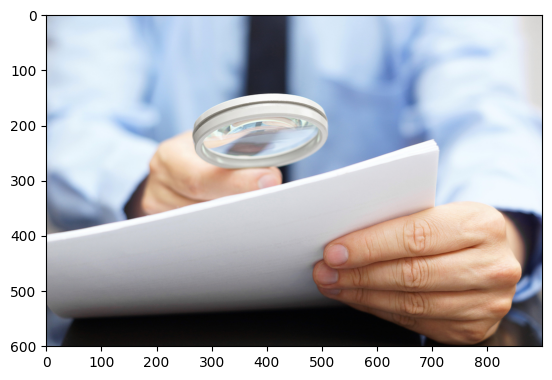

In [181]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from io import BytesIO
banner_image_url = "https://staticx-tuner.zacks.com/images/default_article_images/default341.jpg"
response = requests.get(banner_image_url)

if response.status_code == 200:
    img = mpimg.imread(BytesIO(response.content), format='JPG')
    imgplot = plt.imshow(img)
    plt.show()
else:
    print(f"Failed to retrieve the image. Status code: {response.status_code}")

Set up the huggingface transformer

In [185]:
transformers_version = "v4.29.0" #@param ["main", "v4.29.0"] {allow-input: true}

print(f"Setting up everything with transformers version {transformers_version}")

!pip install huggingface_hub>=0.14.1 git+https://github.com/huggingface/transformers@$transformers_version -q diffusers accelerate datasets torch soundfile sentencepiece opencv-python openai

Setting up everything with transformers version v4.29.0


In [ ]:
import IPython
import soundfile as sf

def play_audio(audio):
    sf.write("speech_converted.wav", audio.numpy(), samplerate=16000)
    return IPython.display.Audio("speech_converted.wav")

from huggingface_hub import notebook_login
notebook_login()

In [193]:
agent_name = "OpenAI (API Key)" #@param ["StarCoder (HF Token)", "OpenAssistant (HF Token)", "OpenAI (API Key)"]

if agent_name == "StarCoder (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent("https://api-inference.huggingface.co/models/bigcode/starcoder")
    print("StarCoder is initialized 💪")
elif agent_name == "OpenAssistant (HF Token)":
    from transformers.tools import HfAgent
    agent = HfAgent(url_endpoint="https://api-inference.huggingface.co/models/OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5")
    print("OpenAssistant is initialized 💪")
if agent_name == "OpenAI (API Key)":
    from transformers.tools import OpenAiAgent
    pswd = openai_apikey
    agent = OpenAiAgent(model="text-davinci-003", api_key=pswd)
    print("OpenAI is initialized 💪")

tool_config.json:   0%|          | 0.00/226 [00:00<?, ?B/s]

tool_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

tool_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

tool_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

OpenAI is initialized 💪


In [194]:
caption = agent.run("Can you caption the `image`?", image=img)

==Explanation from the agent==
I will use the following  tool: `image_captioner` to generate a caption for the image.


==Code generated by the agent==
caption = image_captioner(image)
print(f"The caption is {caption}.")


==Result==


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/opt/conda/lib/python3.11/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


The caption is a man holding a white piece of paper and a magnifying a magnifying a mag.


In [201]:
data = {
  "text": caption,
  "model_id": "eleven_monolingual_v1",
  "voice_settings": {
    "stability": 0.5,
    "similarity_boost": 0.5
  }
}

response = requests.post(url, json=data, headers=headers)
with open('output.mp3', 'wb') as f:
    for chunk in response.iter_content(chunk_size=CHUNK_SIZE):
        if chunk:
            f.write(chunk)

audio_file = 'output.mp3'

audio = Audio(filename=audio_file, autoplay =True)
display(audio)